# DS 504 Big data analytics project2

2. find intersection __center__
3. weighted by __dist__ from intersections
4. transform plot to show stop/run pattern (log, __1/x__, ...)
5. remove noises

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np
import os, random, sys

JoinResPath = "./data/JoinResults/"
Ilist = [i for i in os.listdir(JoinResPath) if not i.startswith(".")]

def readJR(Id=None,LEAST = 100):
    #least: threshold for number of trajectory points
    Iid = (str(Id) if type(Id)==int else Id) if Id else random.choice(Ilist)
    with open(JoinResPath+Iid,"rb") as f:
        res = []
        for i in f:
            res.append(i.strip().split(","))
    df = pd.DataFrame(res[1:])
    if not Id and not len(df)>LEAST:
        return readJR(None,LEAST)
    df[1],df[2], df[3] = pd.to_datetime(df[1]), df[2].astype(float), df[3].astype(float) 
    return (int(res[0][0]),float(res[0][1]),float(res[0][2])),df.sort_values([0,1])
    
def plotJR(c,df,**kargs):
    plt.scatter(df[2],df[3],**kargs)
    plt.scatter(float(c[1]),float(c[2]),color="r",s=30)
    xl,xu,yl,yu=df[2].min(),df[2].max(),df[3].min(),df[3].max()
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(df)))

def spliTraj(df,**rng):
    curr, last = None, None
    currID, lastID = None, None
    split=[0]
    for i in xrange(df.shape[0]):
        if type(curr)!=type(None):
            last, lastID = curr,currID
        curr,currID = df.iloc[i,1],df.iloc[i,0]
        if type(last)!=type(None):
            if curr>pd.DateOffset(**rng)+last or currID!=lastID:
                split.append(i)
    split.append(i+1)
    #return split
    ret = []
    for i in xrange(1,len(split)):
        splited=df.iloc[split[i-1]:split[i],:]
        ret.append(splited)
    return sorted(ret,cmp=lambda x,y:cmp(x.iloc[0,1],y.iloc[0,1]))
    
def plotJR_line(c,dfs,**kargs):
    plt.scatter(c[1],c[2],color="r",s=30)
    if type(dfs)!=list:dfs=[dfs]
    for df in dfs: 
        for t in set(df.iloc[:,0]):    
            if len(df)>1:plt.plot(df.iloc[:,2],df.iloc[:,3],**kargs)
    dfs=pd.concat(dfs)
    xl,xu,yl,yu=dfs[2].min(),dfs[2].max(),dfs[3].min(),dfs[3].max() 
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(dfs)))
    
def timeRange(df,time,**rng):
    if len(rng)==0:return df
    if type(df)!=list: 
        mask = df.ix[:,1]<time+pd.DateOffset(**rng)
        mask &= df.ix[:,1]>=time
        return None if df.ix[mask,:].empty else df.ix[mask,:]
    else:
        ret = []
        for i in df:
            tmp=timeRange(i,time,**rng)
            if type(tmp)!=type(None):ret.append(tmp)
        return ret

def calc_features(dfs,verbose=0):
    features=[]
    count=0
    for df in dfs:
        if len(df)<2:continue
        tdiff,xdiff,ydiff = [df[i].diff().iloc[1:] for i in (1,2,3)]
        d = list(np.sqrt(xdiff**2+ydiff**2))
        xd = [0 if np.isnan(i) else i for i in (np.divide(xdiff,d))]
        yd = [0 if np.isnan(i) else i for i in (np.divide(ydiff,d))]
        v = list(d/tdiff.astype('timedelta64[s]'))
        features.append({"time":list(df[1]),"status":np.vstack([v,xd,yd]).T})
        if verbose:
            count+=1
            print "\r%d/%d" % (count,len(dfs))
    return features

(3925, 22.5361325, 114.0193383) (22.534134000000002, 114.01738, 22.538115999999999, 114.021332)
http://maps.google.com/maps?z=12&t=k&q=loc:22.536133+114.019338


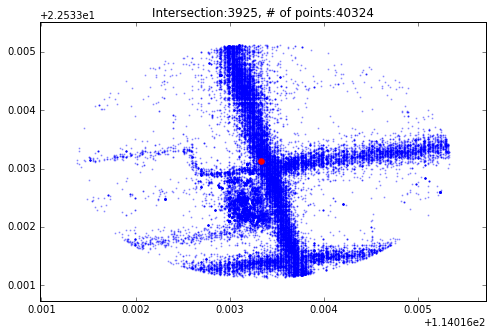

In [15]:
#3420,2076,3712,1138,4133,3693,4951,2000
center,points = readJR(LEAST=3000)
print(center[0],center[2],center[1]),(points[3].min(),points[2].min(),points[3].max(),points[2].max())
print "http://maps.google.com/maps?z=12&t=k&q=loc:%f+%f" % (center[2],center[1])
plt.figure(figsize=(8,5))
plotJR(center,points,s=1,color="b",alpha=.3)
plt.show()

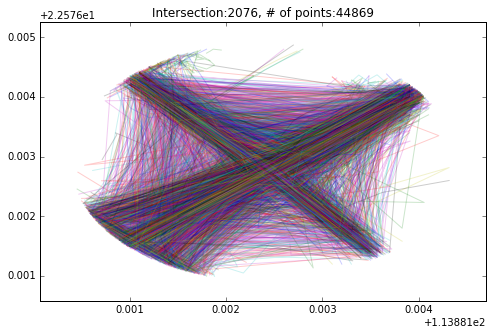

In [3]:
# Tunning Variable
SPLIT_INTERVAL = {"minutes":1,"hours":0,"seconds":0}

plt.figure(figsize=(8,5))
splitTJ = spliTraj(points,**SPLIT_INTERVAL)
plotJR_line(center,splitTJ,alpha=.2)
plt.show()

In [5]:
# Tunning Variables
TIME_RNG = {"hours":24}

rngres = timeRange(splitTJ,pd.Timestamp("00:00:00"),**TIME_RNG)
features=calc_features(rngres)
"# of trajectories: %d"%len(rngres)

'# of trajectories: 13417'

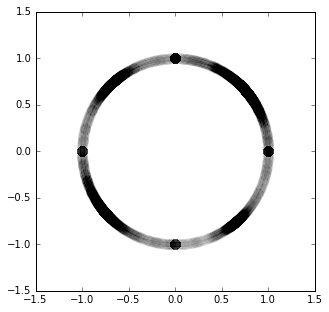

In [6]:
cuml_dirs = []
for i in features:
    filter_ = i["status"][:,1:3].sum(axis=1)!=0.0
    ##remove 1,0
    #filter_ &= abs(i["status"][:,1:3].sum(axis=1))!=1
    cuml_dirs.append(i["status"][filter_,1:3])
cuml_dirs = np.vstack(cuml_dirs)
plt.figure(figsize=(5,5))
plt.scatter(cuml_dirs[:,0],cuml_dirs[:,1],s=100,color="k",alpha=0.002)
plt.show()

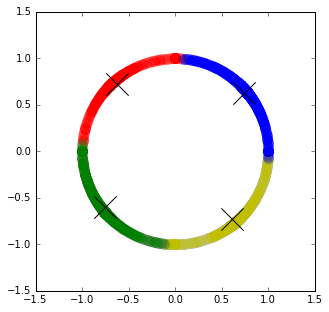

In [7]:
from sklearn.cluster import KMeans
from pyclust import KMedoids

# Tunning Variables
# for now, this param must be tuned manually
# Cuz KMedoids is a fast algo(KMeans is faster), but must give it a param.
DIRECTION_NUM=4

if len(cuml_dirs)<10000:
    model = KMedoids(n_clusters=DIRECTION_NUM)
    model.fit(cuml_dirs)
    directions = model.centers_
else:
    model = KMeans(n_clusters=DIRECTION_NUM)
    model.fit(cuml_dirs)
    directions = model.cluster_centers_
labels = model.labels_
plt.figure(figsize=(5,5))
colors="rybgkmc"*30
for i in list(set(model.labels_)):
    plt.scatter(cuml_dirs[labels==i,0],cuml_dirs[labels==i,1],
                s=100,alpha=0.01,color=colors[i])
plt.scatter(directions[:,0],directions[:,1],marker="x",s=500,color="k")
plt.show()
del model

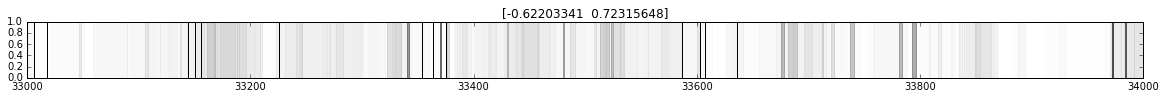

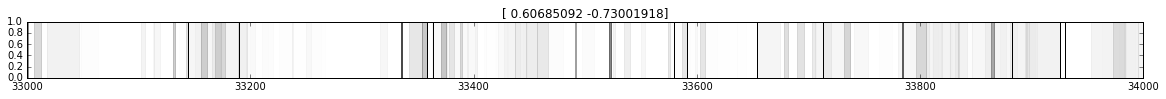

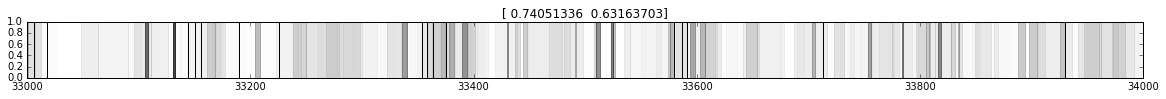

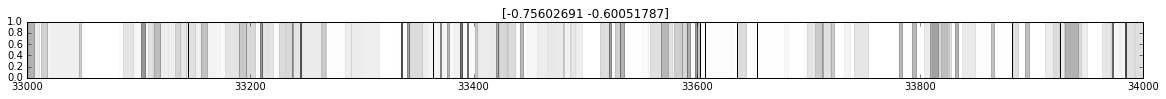

In [9]:
def plot_status(feature,direction=None):
    STARTTIME = pd.Timestamp("00:00:00")
    starts = [(i-STARTTIME).seconds for i in [STARTTIME]+feature["time"]]
    bins = np.diff(starts)
    if type(direction) != type(None):
        cosine = np.dot(feature["status"][:,1:3],direction)/sqrt(2)
        similarity = map(lambda x:max([0,x]),cosine)
        y = feature["status"][:,0]*similarity
    else: y = feature["status"][:,0]
    for i in xrange(len(y)):
        plt.bar(starts[i:i+2],[0,1],bins[i:i+2],alpha=1-.001/(.001+y[i]),color="k",edgecolor = "none")


for direction in list(directions):
    plt.figure(figsize=(20,1))
    for i in features[:]:
        plot_status(i,direction)
    plt.title(direction)
    plt.xlim([33000,34000])
    plt.show()


In [10]:
def monitoring(monitor,feature,direction): 
    starts = [(i-pd.Timestamp("00:00:00")).seconds for i in feature["time"]]
    if type(direction) != type(None):
        cosine = np.dot(feature["status"][:,1:3],direction)/sqrt(2)
        similarity = map(lambda x:max([0,x]),cosine**9)
        y = feature["status"][:,0]*similarity
    else: y = feature["status"][:,0]
    for i in xrange(len(y)):
        for j in xrange(starts[i],starts[i+1]):
            monitor[j].append(y[i])

speed_monitors=[]            
for direction in directions:
    speed_monitor=[[] for i in xrange(86400)]
    for feature in features:
        monitoring(speed_monitor,feature,direction)
    speed_monitors.append(speed_monitor)
print "Done!"   

Done!


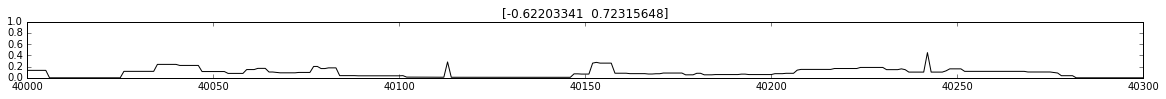

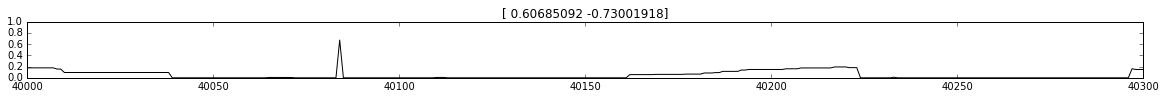

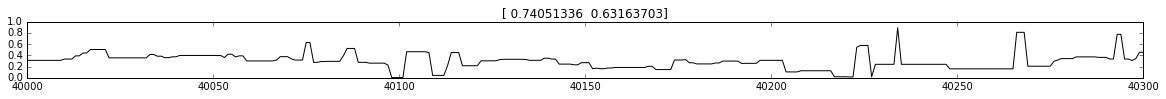

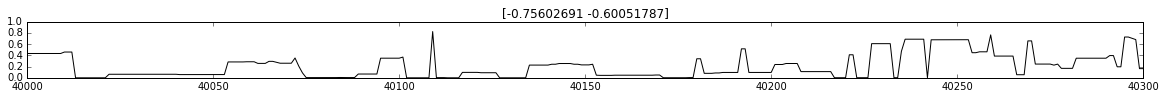

In [11]:
def wrapped(x):
    if len(x)==0:return 0
    return np.nanmean([i for i in x if np.isfinite(i)])
trends=[]
for i in xrange(4):
    trend = []
    for j in speed_monitors[i]:
        trend.append(wrapped(j))
    trends.append(trend)
    plt.figure(figsize=(20,1))
    plt.plot(1-1/(1+1e6*np.array(trend)),color="k")
    plt.xlim([40000,40300])
    plt.title(directions[i])
    plt.show()

In [12]:
from sklearn.preprocessing import scale
np.corrcoef(scale(trends))

array([[ 1.        , -0.15465651, -0.33034582, -0.35145844],
       [-0.15465651,  1.        , -0.32509417, -0.31592192],
       [-0.33034582, -0.32509417,  1.        , -0.48212551],
       [-0.35145844, -0.31592192, -0.48212551,  1.        ]])

           0                   1           2          3
24175  26779 2016-04-11 00:08:08  113.882004  22.580299


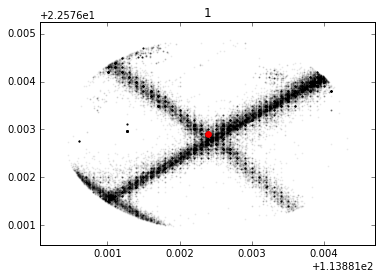

           0                   1           2        3
21821  22871 2016-04-11 00:08:10  113.882202  22.5805


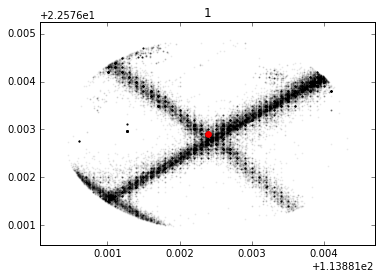

           0                   1           2          3
1657   24092 2016-04-11 00:08:22  113.883904  22.578400
1658   24092 2016-04-11 00:08:37  113.883064  22.578568
11564  24092 2016-04-11 00:08:52  113.881714  22.578217


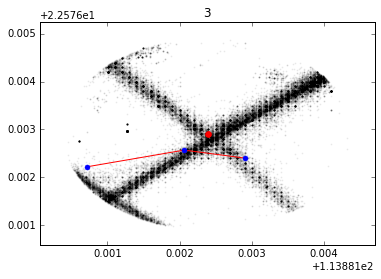

           0                   1           2          3
24969  29051 2016-04-11 00:08:22  113.882301  22.580099


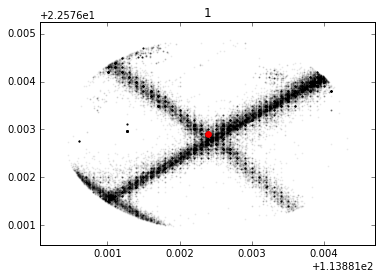

In [13]:
for i in timeRange(splitTJ,pd.Timestamp("12:00:00"))[100:104]:
    print i
    plotJR_line(center,i,marker=".",ms=10,mec="b",mfc="b",color="r")
    plotJR(center,points,color="k",s=1,alpha=.05)
    plt.title("%d"%len(i))
    plt.show()